In [ ]:
https://github.com/zbg201/bee2041_p1

This document is adapted from a lab prepared by Alex Rutherford, with permission

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import random as rd
import numpy as np

# Setup

In this part we are going to code our own simulation using python. What we are going to model the spread of a virus over a network of agents (e.g. people or computers). Read carefully this section, you'll not be asked to do anything, your only duty is to understand what we are going to do.

First step is to model the problem, and in the case of multi-agent systems this means to give agent characteristics and capacities of interaction. For viral infection it is obvious that the only thing that matters is to know whether agent is infected, and how infection propagates. The infection status of an agent will be modeled by a state variable. Our model choice for infection will be that the infection spreads through links between agents (e.g. social links or communication links) with a given probability. As a consequence, the obvious representation for our simulation is a graph.

Second step is to implement this model in a programing language, and more specifically within the class in Python. The natural python representation for our model is a networkx graph whose nodes represent the agent and to which additional information regarding the state will be attached. Fortunately there is a very simple way of handling information attached to nodes in networkx: You access attributes through the node field of a graph object, for instance to add a label called first name to the node 0 of graph g with the value Jean, you would write:

In [2]:
g = nx.Graph()
g.add_node(0)
g.nodes[0]['first name'] = "Jean"

And to access to the value, you would write:

In [3]:
print(g.nodes[0]['first name'])

Jean


Another crucial thing to learn is how probabilities materialise in the simulation. When we use an infection rate of 0.2, this means two infections out of 10 attempts. We will simulate this by generating a random number between 0 and 1, and then checking if this number is less than 0.2. For example, try to run the following cell 10 times and see if you get a "Yes" about 2 times (it's not gonna be exactly two times, perhaps once or three times):

In [4]:
if rd.random() < 0.2:
    print("Yes")
else:
    print("No")

Yes


Now look at the code below. The state of an agent is stored under the label `state`. Different values of the states are represented as integers. However for conveniance we give names to these integers: `agSusceptible`, `agInfected`
and `agRecovered`. A susceptible agent can be infected if he never got the virus, a recovered agent can not get the virus again.

The dynamic of the system is also a bit more complex than what we previously exposed: an infection can start with a given probability on any given node for any given link, recovery can stop with a given probability.

Simulation proceeds in clear steps, enclosed within the step function. This function loops over all the agents and update their state based on the dynamic of the system. Please note that the state of the agents are not updated on the current graph, but on a new graph representing the next state of the system. This new state is substituted at the end of the step to become the new current state of the system. This technique is important as it allows a synchronous update of the state of all the agents.

In [5]:
# simulation parameters

In [6]:
# model parameters

## infection

probInfection = 0.2
probRecovery = 0.2
probInfectionResidual = 0.0

randomInitialInfection=True

In [7]:
## communication structure


# model states

systemState = None
nextSystemState = None

agSusceptible = 0
agInfected = 1
agRecovered = 2

In [8]:
# helper functions
def test_state(n,value):
    global systemState
    return systemState.nodes[n]['state'] == value

In [9]:
# model dynamics
def init(network, nba, netParam, probInfectionInit):
    global systemState
    
    # generate communication strucure
    systemState = network(nba, netParam)

    # init agents' states
    if randomInitialInfection:
        # random infection
        for a in systemState.nodes():
            if rd.random() < probInfectionInit:
                systemState.nodes[a]['state'] = agInfected
            else:
                systemState.nodes[a]['state'] = agSusceptible

In [10]:
def step():
    global systemState

    # copy current network structure and agent s'states
    nextSystemState = systemState.copy()

    # determine next agents' state
    for a in systemState.nodes():
        # if infected
        if test_state(a,agInfected):
            # first try to recover
            if rd.random() < probRecovery:
                nextSystemState.nodes[a]['state'] = agRecovered
            # if not try to propagage virus
            else:
                for n in systemState.neighbors(a):
                    # if recovered, do nothing
                    if test_state(n,agRecovered):
                        pass
                    # otherwise try to infect
                    elif test_state(n,agSusceptible):
                        if rd.random() < probInfection:
                            nextSystemState.nodes[n]['state'] = agInfected
    systemState = nextSystemState

In [11]:
def collect_statistics():
    global systemState

    nbS = 0
    nbI = 0
    nbR = 0
    nbM = 0
    for a in systemState.nodes():
        if test_state(a,agSusceptible):
            nbS = nbS + 1
        if test_state(a,agInfected):
            nbI = nbI + 1
        if test_state(a,agRecovered):
            nbR = nbR + 1
    return nbS, nbI

In [12]:
def display_statistics(x, er, ba, xlabel):
    plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel('Percentage of Infected Agents')
    plt.plot(x, er ,label="Erdos-Renyi",marker='o', color="r")
    plt.plot(x, ba ,label="Barabasi Albert",marker='o', color="b")
    #plt.plot(statI,label="I", color="r")
    #plt.plot(statR,label="R", color="g")

    plt.legend()
    plt.show()

In [13]:
def draw():
    global systemState

    list_colors = []
    for a in systemState.nodes():
        if test_state(a,agSusceptible):
            list_colors.append("b")
        if test_state(a,agInfected):
            list_colors.append("r")
        if test_state(a,agRecovered):
            list_colors.append("g")

    nx.draw(systemState, node_color = list_colors)
    plt.show()

processing ER...
processing BA...


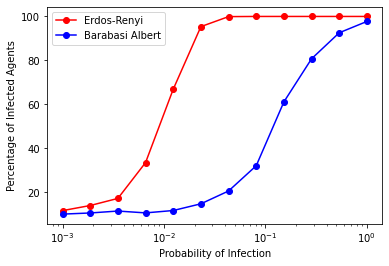

processing ER...
processing BA...


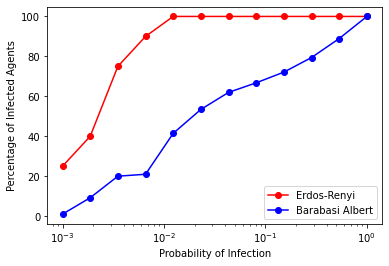

processing ER...
processing BA...


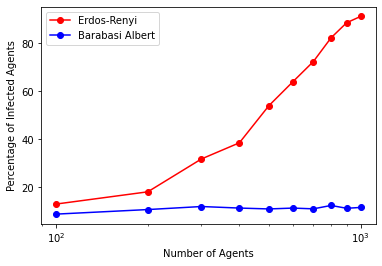

In [14]:
def run_simulation(nba, maxIter, probI, probR, probI_init, network, netParam, rep):
    global probInfection
    global probRecovery
    probInfection = probI
    probRecovery = probR
    totalStatS = 0
    for x in range(0, rep):
        init(network, nba, netParam, probI_init)
        statS = []
        i = 0
        while i < maxIter:
            step()
            nbS, nbI = collect_statistics()
            statS.append(nbS)
            if nbI == 0:
                break
            i = i + 1
        totalStatS += statS[-1]   
    perOfInfectedAgents = (nba - totalStatS / rep) / nba * 100
    return perOfInfectedAgents

if __name__ == "__main__":
    x = np.logspace(-3,0,12)
    er = []
    ba = []
    print("processing ER...")
    for i in x:
        perOfInfectedAgents = run_simulation(500, 10, i, .2, .1, nx.erdos_renyi_graph, .1, 10)
        er.append(perOfInfectedAgents)
        #print("Probability of Infection:", i, " | Percentage of Infected Agents:", perOfInfectedAgents)
    print("processing BA...")
    for i in x:
        perOfInfectedAgents = run_simulation(500, 10, i, .2, .1, nx.barabasi_albert_graph, 2, 10)
        ba.append(perOfInfectedAgents)
        #print("Probability of Infection:", i, " | Percentage of Infected Agents:", perOfInfectedAgents)
    display_statistics(x, er, ba, 'Probability of Infection')
    
    er = []
    ba = []
    print("processing ER...")
    for i in x:
        perOfInfectedAgents = run_simulation(500, 10, .2, .2, i, nx.erdos_renyi_graph, .1, 20)
        er.append(perOfInfectedAgents)
        #print("Probability of Infection:", i, " | Percentage of Infected Agents:", perOfInfectedAgents)
    print("processing BA...")
    for i in x:
        perOfInfectedAgents = run_simulation(500, 10, .2, .2, i, nx.barabasi_albert_graph, 2, 20)
        ba.append(perOfInfectedAgents)
        #print("Probability of Infection:", i, " | Percentage of Infected Agents:", perOfInfectedAgents)
    display_statistics(x, er, ba, 'Probability of Infection')
    
    x = np.arange(100,1100,100)
    er = []
    ba = []
    print("processing ER...")
    for i in x:
        perOfInfectedAgents = run_simulation(i, 10, .01, .2, .1, nx.erdos_renyi_graph, .1, 10)
        er.append(perOfInfectedAgents)
        #print("Number of agents:", i, " | Percentage of Infected Agents:", perOfInfectedAgents)
    print("processing BA...")
    for i in x:
        perOfInfectedAgents = run_simulation(i, 10, .01, .2, .1, nx.barabasi_albert_graph, 2, 10)
        ba.append(perOfInfectedAgents)
        #print("Number of agents:", i, "| Percentage of Infected Agents:", perOfInfectedAgents)
    display_statistics(x, er, ba, 'Number of Agents')